# 1 言語判別

### 準備

In [1]:
import sys
import pickle
import numpy as np
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

random_state = 12

epochs = 20

# iLect環境用  ./が効かないようなので
f_dir = '/root/userspace/dl4us_final_report/'

Using TensorFlow backend.


In [2]:
# 関数

def cha_cnt(doc):
    ''' 文字をユニコードで分け数える '''

    doc = re.sub(r'[\n\t\s]', '', doc)
    doc = doc.lower()  # 大文字を小文字に

    cnt = [0] * 36
    for c in doc:
        uni = ord(c)
        if uni in range(0x61, 0x7B):  # a~z -> cnt[0]~cnt[25]
            cnt[uni - 0x61] += 1
            continue
        if uni in range(0x3040, 0x309F):  # ひらがな
            cnt[26] += 1
            continue
        if uni in range(0x30A1, 0x30FF):  # カタカナ
            cnt[27] += 1
            continue
        if uni in range(0x4E00, 0x5000):  # CJK統合漢字
            cnt[28] += 1
            continue
        if uni in range(0x5000, 0x6000):  # CJK統合漢字
            cnt[29] += 1
            continue
        if uni in range(0x6000, 0x7000):  # CJK統合漢字
            cnt[30] += 1
            continue
        if uni in range(0x7000, 0x8000):  # CJK統合漢字
            cnt[31] += 1
            continue
        if uni in range(0x8000, 0x9000):  # CJK統合漢字
            cnt[32] += 1
            continue
        if uni in range(0x9000, 0xA000):  # CJK統合漢字
            cnt[33] += 1
            continue
        if uni in range(0x3400, 0x4E00):  # CJK統合漢字(extension A)
            cnt[34] += 1
            continue
        cnt[35] += 1  # そのほか

    return cnt


def lang_dic():
    ''' 言語の 文字 <-> 番号 変換用辞書 '''

    dic = {'en': 0, 'ja': 1}

    return dic


def lang2id(cha):
    ''' 言語の文字を番号に '''

    dic = lang_dic()

    return dic[cha]


def id2lang(id):
    ''' 言語の番号を文字に '''

    dic_rev = {i: l for l, i in lang_dic().items()}

    return dic_rev[id]

## 1.1 学習

In [3]:
# データ読み込み
en_docs = pickle.load(open(f_dir + 'pickles/en_docs.pickle', 'rb'))
ja_docs = pickle.load(open(f_dir + 'pickles/ja_docs.pickle', 'rb'))

# 訓練データ整形（x:文字数リスト, y:言語ラベル）
x_cha_cnt = [cha_cnt(doc) for doc in (en_docs + ja_docs)]
y_lang = ['en'] * len(en_docs) + ['ja'] * len(ja_docs)

# データ正規化
x1 = np.array(x_cha_cnt, dtype='float')
x1 = x1 / np.sum(x1, axis=1).reshape(-1, 1)  # 文字出現数を出現割合に
y1 = [lang2id(c) for c in y_lang]
y1 = np.eye(len(lang_dic()))[y1]  # 言語ラベル -> 1-hot表現に

# train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=2000, random_state=random_state)

# MLPモデル構築
inputs = Input(shape=(36,))
x = Dense(24, activation='relu', kernel_initializer='he_normal')(inputs)
x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(4, activation='relu', kernel_initializer='he_normal')(x)
y = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 学習
earlystopping = EarlyStopping(patience=5, verbose=1)
fit1 = model.fit(x1_train, y1_train, batch_size=1000, verbose=2, epochs=epochs, validation_data=(x1_test, y1_test),
          callbacks=[earlystopping])

model.save(f_dir + 'models/di_lang_mlp.h5')

Train on 26222 samples, validate on 2000 samples
Epoch 1/20
 - 3s - loss: 0.6652 - acc: 0.8925 - val_loss: 0.6185 - val_acc: 0.9975
Epoch 2/20
 - 0s - loss: 0.5740 - acc: 0.9930 - val_loss: 0.4818 - val_acc: 0.9990
Epoch 3/20
 - 0s - loss: 0.4069 - acc: 0.9957 - val_loss: 0.2774 - val_acc: 1.0000
Epoch 4/20
 - 0s - loss: 0.2152 - acc: 0.9969 - val_loss: 0.1084 - val_acc: 1.0000
Epoch 5/20
 - 0s - loss: 0.0923 - acc: 0.9974 - val_loss: 0.0353 - val_acc: 1.0000
Epoch 6/20
 - 0s - loss: 0.0424 - acc: 0.9971 - val_loss: 0.0133 - val_acc: 1.0000
Epoch 7/20
 - 0s - loss: 0.0236 - acc: 0.9979 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 8/20
 - 0s - loss: 0.0158 - acc: 0.9995 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 9/20
 - 0s - loss: 0.0106 - acc: 0.9998 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 10/20
 - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 11/20
 - 0s - loss: 0.0065 - acc: 1.0000 - val_loss: 7.3954e-04 - val_acc: 1.0000
Epoch 12/20
 - 0s - loss: 0.0050

## 1.2 学習経過の記録

In [5]:
import pandas as pd

list_ = [fit1.history['loss'], fit1.history['val_loss'], fit1.history['acc'], fit1.history['val_acc']]
df = pd.DataFrame(list_, index=['loss', 'val_loss', 'acc', 'val_acc'], columns=range(1, epochs + 1))
df.to_pickle(f_dir + 'histories/fit1_history_df.pickle')
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
loss,0.665171,0.574040,0.406859,0.215179,0.092314,0.042381,0.023589,0.015818,0.010646,0.008141,0.006488,0.005012,0.004290,0.003896,0.003267,0.003094,0.002977,0.002181,0.001845,0.002306
val_loss,0.618473,0.481754,0.277424,0.108385,0.035322,0.013328,0.006136,0.003210,0.001829,0.001132,0.000740,0.000504,0.000353,0.000257,0.000194,0.000150,0.000118,0.000093,0.000075,0.000061
acc,0.892457,0.992983,0.995652,0.996873,0.997407,0.997064,0.997903,0.999542,0.999809,0.999809,0.999962,0.999847,0.999924,0.999733,0.999847,0.999733,0.999695,0.999886,0.999962,0.999733
val_acc,0.997500,0.999000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


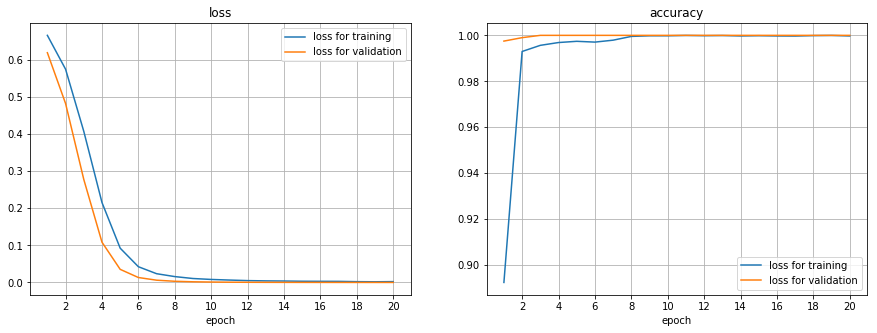

In [6]:
%matplotlib inline

# loss, accu plot
fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(121)
ax1.set_title('loss')
ax1 = df.loc['loss'].plot(label='loss for training')
ax1 = df.loc['val_loss'].plot(label='loss for validation')
ax1.set_xlabel('epoch')
ax1.set_xticks(range(2, epochs+1, 2))
ax1.grid()
ax1.legend()
ax2 = fig1.add_subplot(122)
ax2.set_title('accuracy')
ax2 = df.loc['acc'].plot(label='loss for training')
ax2 = df.loc['val_acc'].plot(label='loss for validation')
ax2.set_xlabel('epoch')
ax2.set_xticks(range(2, epochs+1, 2))
ax2.grid()
ax2.legend()

fig1.savefig(f_dir + 'figures/fit1_plot.png')

## 1.3 予測

### データを準備

In [7]:
# 全データをシャッフルする
all_docs = en_docs + ja_docs  # 本文
en_cats = pickle.load(open(f_dir + 'pickles/en_categories.pickle', 'rb'))
ja_cats = pickle.load(open(f_dir + 'pickles/ja_categories.pickle', 'rb'))
all_cats = en_cats + ja_cats  # カテゴリ

# 本文、正解カテゴリ、言語判別用配列、言語(1-hot)、をまとめてシャッフル
zipped = list(zip(all_docs, all_cats, x1, y1))
random.shuffle(zipped)
shf_docs, shf_cats, x1_shf, y1_shf = zip(*zipped)

shf_docs, shf_cats, x1_shf, y1_shf = list(shf_docs), list(shf_cats), np.array(x1_shf), np.array(y1_shf)

### 予測

In [8]:
y1_predict_1h = model.predict(x1_shf)

# 1-hot表現から数値に
y1_predict_n = np.argmax(y1_predict_1h, axis=1)
y1_true_n = np.argmax(y1_shf, axis=1)

# 正解と違うラベルを数える
inc = sum([0 if y1_predict_n[i] == y1_true_n[i] else 1 for i in range(len(y1_true_n))])

print('num of incorrect:', inc)
print('accuracy:', accuracy_score(y1_true_n, y1_predict_n))
print('f1_score:', f1_score(y1_true_n, y1_predict_n, average='macro'))

num of incorrect: 0
accuracy: 1.0
f1_score: 1.0


### データを保存

In [9]:
# ラベル保存用に言語を文字 en, ja に戻す
shf_lang = np.argmax(y1_shf, axis=1)
shf_lang = [id2lang(i) for i in shf_lang]

shf_labels = [(cat, lan) for cat, lan in zip(shf_cats, shf_lang)]

# シャッフルした本文とラベルのデータを保存
pickle.dump(shf_docs, open(f_dir + 'pickles/shf_docs.pickle', 'wb'))
pickle.dump(shf_labels, open(f_dir + 'pickles/shf_labels.pickle', 'wb'))